#**Attention**: Markdowns here are just considered as comments and report has been written separately!

**Attention**: Colab environment is used.

In [0]:
import numpy as np
import cv2
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt
from skimage import data, feature, color, transform
from sklearn.feature_extraction.image import PatchExtractor
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from skimage.transform import pyramid_gaussian
from imutils.object_detection import non_max_suppression


#Part 3 & 4

##Load the Labeled Faces in the Wild (LFW) people dataset

In [2]:
# Load the Labeled Faces in the Wild (LFW) people dataset
faces = fetch_lfw_people()
positive_patches = faces.images

print(f'Number of positive samples is {positive_patches.shape[0]}')

Number of positive samples is 13233


##Negative Training Samples

In [0]:
# Negative Training Samples
img_to_use = ['camera',
              'text',
              'coins',
              'moon',
              'page',
              'clock',
              'immunohistochemistry',
              'chelsea',
              'coffee',
              'hubble_deep_field',
              'brick',
              'grass',
              'horse',
              'logo',
              'rocket']

images = [color.rgb2gray(getattr(data, name)()) for name in img_to_use]

##Extract Meaningful Patches Using Different Scales

In [4]:
# Extract Meaningful Patches Using Different Scales
def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
print(f'The shape of negative patches is {negative_patches.shape}')

The shape of negative patches is (45000, 62, 47)


## Plot some of Negative Patches

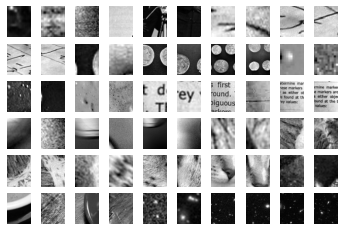

In [5]:
fig , ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
  axi.imshow(negative_patches[500*i], cmap='gray')
  axi.autoscale()
  axi.axis('off')

##Extract HOG Features(+ part 4)

In [0]:
dataset = np.array([feature.hog(img) for img in chain(positive_patches, negative_patches)])

# Label 1 for Faces and 0 for non-Faces
labels = np.zeros(dataset.shape[0])
labels[:positive_patches.shape[0]] = 1

In [7]:
dataset.shape

(58233, 1215)

#Part 5

##Split Dataset into Test and Train

In [8]:
x_train, x_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.2, random_state=42)

print("Shape of Training Set:" + str(x_train.shape))
print("Shape of Test Set:" + str(x_test.shape))


Shape of Training Set:(46586, 1215)
Shape of Test Set:(11647, 1215)


##Train an SVM Model

In [9]:
# Train Linear SVC without Parameter Estimation (using grid serach)
clf = LinearSVC(dual=False, random_state=0, max_iter=15000)
clf.fit(x_train, y_train)

# Test Data Prediction
confidence = clf.score(x_test, y_test)
print("Accuracy on test data :", confidence)


Accuracy on test data : 0.9936464325577402


In [10]:
# Train Linear SVC with Grid Search
grid = GridSearchCV(LinearSVC(dual=False), {'C': [0.01, 0.05, 1.0, 2.0, 4.0]})
grid.fit(x_train, y_train)
print("Best accuracy on training set is : ", grid.best_score_)
print("Best C : ", grid.best_params_)

Best accuracy on training set is :  0.9943974856375808
Best C :  {'C': 1.0}


In [11]:
# Take best estimator and re-train it:
model = grid.best_estimator_
model.fit(x_train,y_train)


LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [12]:
# Accuracy of best estimator on test set:
print("Accuracy of best estimator on test data :", model.score(x_test,y_test))

Accuracy of best estimator on test data : 0.9936464325577402


#Part 6

##Parameters

In [0]:
win_size = positive_patches[0].shape
win_size = (62, 47)
stride = (11, 11)
downscale = 2

##Define Sliding Window Function

In [0]:
def sliding_window(image, win_size, stride):
    for y in range(0, image.shape[0], stride[1]):
        for x in range(0, image.shape[1], stride[0]):
            yield (x, y, image[y:y + win_size[1], x:x + win_size[0]])

##Face Detector

In [0]:
def faceDetector(img):
  # List to store the detected faces
  detections = []

  # Current scale of the image in pyramid
  scale = 0

  # Downscale image
  for im in pyramid_gaussian(img):

    if im.shape[0] < win_size[1] or im.shape[1] < win_size[0]:

      break
    for (x, y, im_window) in sliding_window(im, win_size, stride):

      if im_window.shape[0] != win_size[1] or im_window.shape[1] != win_size[0]:

        continue
      # Extract HOG features
      hog_feature = feature.hog(im_window)
      pred = model.predict([hog_feature])
      if pred == 1 and (model.decision_function([hog_feature])> 1) :
        # print(model.decision_function([hog_feature]))
        detections.append(
            (
             int(x * (downscale ** scale)),
             int(y * (downscale ** scale)),
             int(win_size[0] * (downscale ** scale)),
             int(win_size[1] * (downscale ** scale)),
             model.decision_function([hog_feature])
             )
            
        ) 
    scale+=1
  
  # Visualization and applying non_max_suppression
  image = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
  clone = image.copy() 

  
  for (x, y, w, h, _) in detections:
    cv2.rectangle(image, (x, y), (x + w, y + h), (0,255,0), thickness=2)
  
  rectangles = np.array([[x, y, x+w, y+h] for (x, y, w, h, _) in detections])
  scores = np.array([score[0] for (x, y, w, h, score) in detections]) 

  # non_max_suppression
  nms = non_max_suppression(rectangles, probs = scores, overlapThresh = 0.08)
  for (x1, y1, x2, y2) in nms:
    cv2.rectangle(clone, (x1, y1), (x2, y2), (0, 255, 0), thickness =2)

  # Draw
  plt.imshow(image)
  plt.title("Before applying NMS")
  plt.axis('off')
  plt.show()

  plt.imshow(clone)
  plt.title("Final Detection after applying NMS")
  plt.axis('off')
  plt.show()
  return image, clone







##This part which saves images on my google drive may not be run on your computer because of the paths.

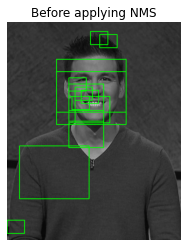

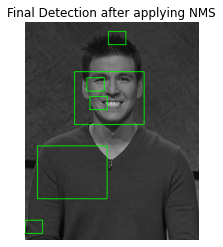

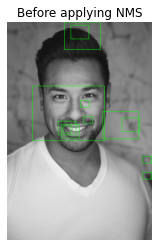

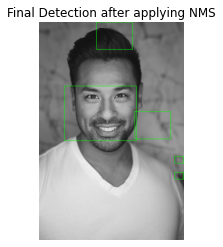

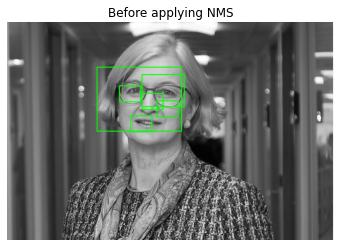

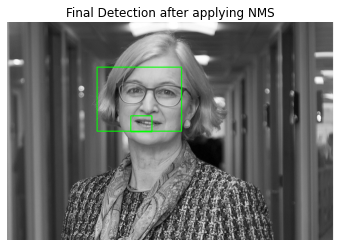

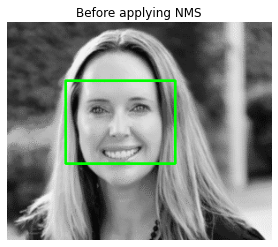

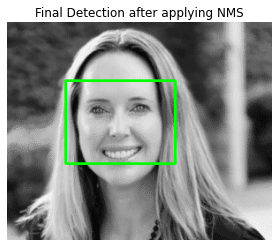

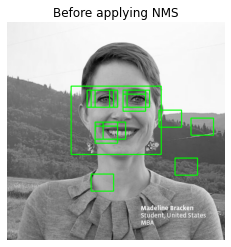

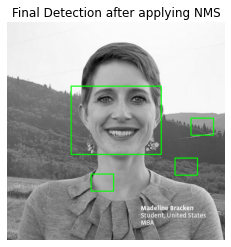

In [19]:
for i in range(5):

  IMAGE = cv2.imread(f'/content/drive/My Drive/Test_images/test_image{i+1}.png', 0)
  image, clone = faceDetector(IMAGE)
  
  cv2.imwrite(f'/content/drive/My Drive/comvis2/beforeNMS_img{i+1}.png', image)
  cv2.imwrite(f'/content/drive/My Drive/comvis2/afterNMS_img{i+1}.png', clone)
